In [1]:
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm  # for kpss
import plotly.graph_objects as go
import warnings
from sklearn.metrics import mean_absolute_percentage_error
from statsmodels.tsa.ar_model import ar_select_order
from statsmodels.tsa.arima.model import ARIMA

warnings.filterwarnings("ignore")

In [2]:
start = "2000-01-01"
end = "2018-12-31"
start_test = "2018-01-01"
end_test = "2024-04-21"

df_vix_raw = yf.download("^VIX", "1999-12-25", end)
df_gspc_raw = yf.download("^GSPC", "1999-12-25", end_test)

df_vix_test = yf.download("^VIX", start_test, end_test)

df_vix_raw.columns = df_vix_raw.columns.str.lower()
df_gspc_raw.columns = df_gspc_raw.columns.str.lower()

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


In [3]:
df_vix_raw['diff_1'] = df_vix_raw['close'].diff(1)
df_vix = df_vix_raw.loc[start:end]
df_vix_test = df_vix_raw.loc[start_test:end_test]

In [4]:
df_gspc_raw["adj close_shift_1"] = df_gspc_raw["adj close"].shift(1)
df_gspc_raw["log_return"] = np.log(
    df_gspc_raw["adj close"] / df_gspc_raw["adj close_shift_1"]
)
df_gspc_raw["simple_return"] = df_gspc_raw["adj close"].pct_change() * 100

In [5]:
df_gspc_raw.loc[start:end]

,open,high,low,close,adj close,volume,adj close_shift_1,log_return,simple_return
Date,,,,,,,,,
2000-01-03,1469.250000,1478.000000,1438.359985,1455.219971,1455.219971,931800000,1469.250000,-0.009595,-0.954911
2000-01-04,1455.219971,1455.219971,1397.430054,1399.420044,1399.420044,1009000000,1455.219971,-0.039099,-3.834467
2000-01-05,1399.420044,1413.270020,1377.680054,1402.109985,1402.109985,1085500000,1399.420044,0.001920,0.192218
2000-01-06,1402.109985,1411.900024,1392.099976,1403.449951,1403.449951,1092300000,1402.109985,0.000955,0.095568
2000-01-07,1403.449951,1441.469971,1400.729980,1441.469971,1441.469971,1225200000,1403.449951,0.026730,2.709040
...,...,...,...,...,...,...,...,...,...
2018-12-24,2400.560059,2410.340088,2351.100098,2351.100098,2351.100098,2613670000,2416.620117,-0.027487,-2.711225
2018-12-26,2363.120117,2467.760010,2346.580078,2467.699951,2467.699951,4249740000,2351.100098,0.048403,4.959374
2018-12-27,2442.500000,2489.100098,2397.939941,2488.830078,2488.830078,4139010000,2467.699951,0.008526,0.856268


In [6]:
df_gspc_test = df_gspc_raw.loc[start_test:end_test].copy()
df_gspc = df_gspc_raw.loc[start:end].copy()
df_gspc_all = df_gspc_raw.loc[start:end_test].copy()

In [7]:
df_vix["adj close_shift_1"] = df_vix["adj close"].shift(1)
df_vix_test = df_vix_test[["close",'diff_1']]

In [8]:
# EDA CHECK
pd.DataFrame.equals(df_vix["close"], df_vix["adj close"])
df_vix = df_vix[["close",'diff_1']]


In [9]:
df_vix.head(5)

,close,diff_1
Date,,
2000-01-03,24.209999,-0.430000
2000-01-04,27.010000,2.800001
2000-01-05,26.410000,-0.600000
2000-01-06,25.730000,-0.680000
2000-01-07,21.719999,-4.010000


In [10]:
df_vix_test.head(5)

,close,diff_1
Date,,
2018-01-02,9.77,-1.270000
2018-01-03,9.15,-0.620001
2018-01-04,9.22,0.070001
2018-01-05,9.22,0.000000
2018-01-08,9.52,0.300000


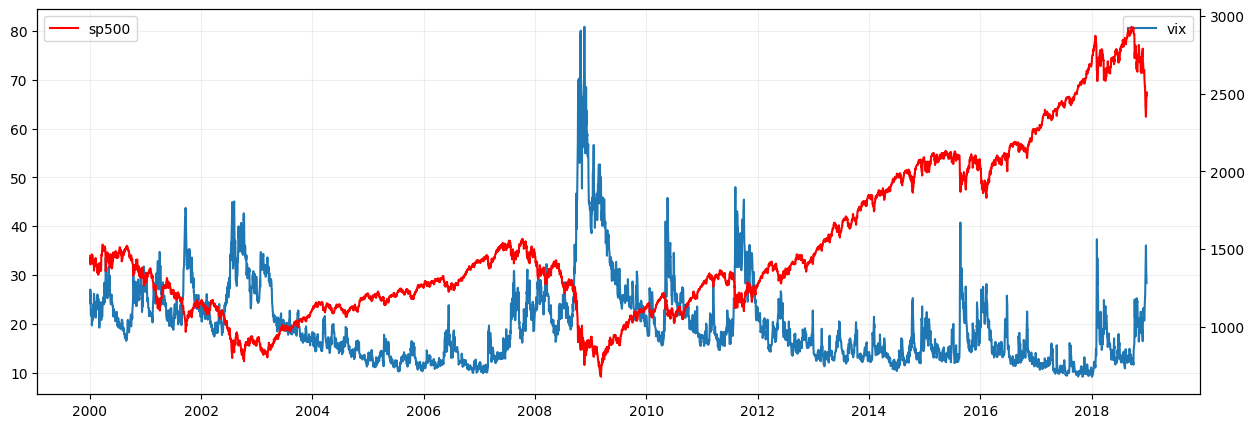

In [11]:
plt.figure(figsize=(15, 5))
plt.grid(alpha=0.2)
plt.plot(df_vix["close"], label="vix")
plt.legend(loc=0)
plt.gca().twinx().plot(df_gspc["close"], color="red", label="sp500")
plt.legend()
plt.show()

# 1. CHECK STATIONARY
https://www.statsmodels.org/stable/examples/notebooks/generated/stationarity_detrending_adf_kpss.html

In [12]:
def kpss_test(timeseries):
    print("Results of KPSS Test:")
    kpsstest = sm.tsa.stattools.kpss(timeseries, regression="c", nlags="auto")
    kpss_output = pd.Series(
        kpsstest[0:3], index=["Test Statistic", "p-value", "Lags Used"]
    )
    for key, value in kpsstest[3].items():
        kpss_output["Critical Value (%s)" % key] = value
    print(kpss_output)

In [13]:
def adf_test(timeseries):
    print("Results of Dickey-Fuller Test:")
    dftest = sm.tsa.stattools.adfuller(timeseries, autolag="AIC")
    dfoutput = pd.Series(
        dftest[0:4],
        index=[
            "Test Statistic",
            "p-value",
            "#Lags Used",
            "Number of Observations Used",
        ],
    )
    for key, value in dftest[4].items():
        dfoutput["Critical Value (%s)" % key] = value
    print(dfoutput)

In [14]:
# NULL = STATIONARY
# ALTERNATE = NON STATIONARY
kpsstest = kpss_test(df_vix['close'])

# Can reject NULL at 95% confidence interval
# The series is not stationary according to the KPSS test

Results of KPSS Test:
Test Statistic            1.448644
p-value                   0.010000
Lags Used                41.000000
Critical Value (10%)      0.347000
Critical Value (5%)       0.463000
Critical Value (2.5%)     0.574000
Critical Value (1%)       0.739000
dtype: float64


In [15]:
# NULL = non stationary
# ALTERNATE = STATIONARY
adftest = adf_test(df_vix['close'])

# Can reject NULL at 95% and 99% confidence interval
# The series has no unit root. (series is stationary)

Results of Dickey-Fuller Test:
Test Statistic                   -4.310837
p-value                           0.000425
#Lags Used                       18.000000
Number of Observations Used    4759.000000
Critical Value (1%)              -3.431725
Critical Value (5%)              -2.862148
Critical Value (10%)             -2.567093
dtype: float64


In [16]:
kpsstest = kpss_test(df_vix['diff_1'])


Results of KPSS Test:
Test Statistic            0.023635
p-value                   0.100000
Lags Used                42.000000
Critical Value (10%)      0.347000
Critical Value (5%)       0.463000
Critical Value (2.5%)     0.574000
Critical Value (1%)       0.739000
dtype: float64


In [17]:
adftest = adf_test(df_vix['diff_1'])


Results of Dickey-Fuller Test:
Test Statistic                -1.758389e+01
p-value                        3.994753e-30
#Lags Used                     1.700000e+01
Number of Observations Used    4.760000e+03
Critical Value (1%)           -3.431725e+00
Critical Value (5%)           -2.862147e+00
Critical Value (10%)          -2.567093e+00
dtype: float64


It is always better to apply both the tests, so that it can be ensured that the series is truly stationary. Possible outcomes of applying these stationary tests are as follows:

Case 1: Both tests conclude that the series is not stationary - The series is not stationary

Case 2: Both tests conclude that the series is stationary - The series is stationary

Case 3: KPSS indicates stationarity and ADF indicates non-stationarity - The series is trend stationary. Trend needs to be removed to make series strict stationary. The detrended series is checked for stationarity.

Case 4: KPSS indicates non-stationarity and ADF indicates stationarity - The series is difference stationary. Differencing is to be used to make series stationary. The differenced series is checked for stationarity.

seems to be case 4 on VIX only, case 2 on diff 1!


In [18]:
kpss_gspc = kpss_test(df_gspc["log_return"].dropna())

Results of KPSS Test:
Test Statistic            0.270319
p-value                   0.100000
Lags Used                19.000000
Critical Value (10%)      0.347000
Critical Value (5%)       0.463000
Critical Value (2.5%)     0.574000
Critical Value (1%)       0.739000
dtype: float64


In [19]:
adf_gspc = adf_test(df_gspc["log_return"].dropna())

Results of Dickey-Fuller Test:
Test Statistic                -1.672857e+01
p-value                        1.389272e-29
#Lags Used                     1.700000e+01
Number of Observations Used    4.761000e+03
Critical Value (1%)           -3.431724e+00
Critical Value (5%)           -2.862147e+00
Critical Value (10%)          -2.567093e+00
dtype: float64


# ACF TEST

In [20]:
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf

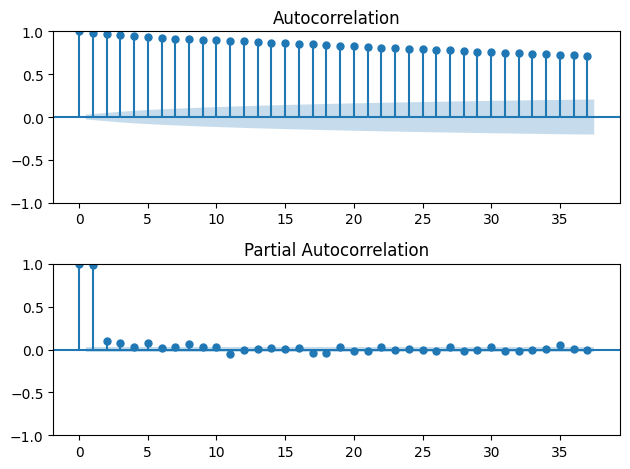

In [21]:
f, ax = plt.subplots(nrows=2, ncols=1)
plot_acf(df_vix["close"], ax=ax[0])
plot_pacf(df_vix["close"], ax=ax[1], method="ols")
plt.tight_layout()
plt.show()

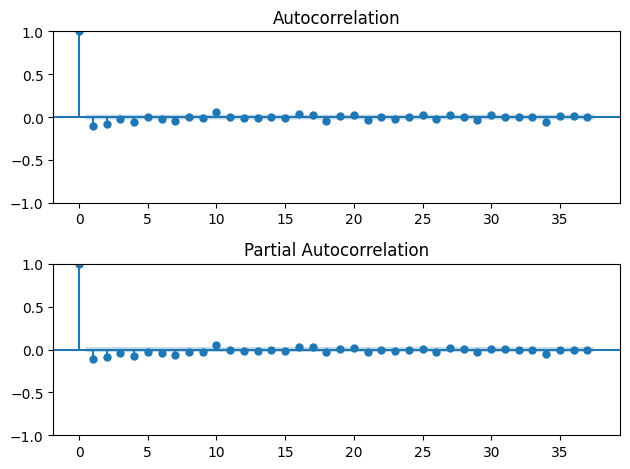

In [22]:
f, ax = plt.subplots(nrows=2, ncols=1)
plot_acf(df_vix["diff_1"], ax=ax[0])
plot_pacf(df_vix["diff_1"], ax=ax[1], method="ols")
plt.tight_layout()
plt.show()

# 1B. AR(1) MODEL FOR VIX

In [23]:


model=ARIMA(df_vix["close"],order=(1,0,0))
res=model.fit()
print(res.summary())
ar_params = res.arparams
ma_params = res.maparams
print(f"AR PARAMS : {ar_params}")
print(f"MA PARAMS : {ma_params}")
prediction = res.predict(start=df_vix_test.index[0], end = df_vix_test.index[-1])

predictions = pd.DataFrame(
    {
        "AR": prediction,
        "Actual": df_vix_test["close"],
    }
)
print(f" Mean Abs Percentage Error(%) :{mean_absolute_percentage_error(df_vix_test["close"], prediction) * 100} %")

                               SARIMAX Results                                
Dep. Variable:                  close   No. Observations:                 4778
Model:                 ARIMA(1, 0, 0)   Log Likelihood               -9255.422
Date:                Sat, 02 Nov 2024   AIC                          18516.845
Time:                        14:57:49   BIC                          18536.260
Sample:                             0   HQIC                         18523.665
                               - 4778                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         19.7215      1.689     11.675      0.000      16.411      23.032
ar.L1          0.9807      0.001    681.975      0.000       0.978       0.984
sigma2         2.8170      0.018    154.663      0.0

In [24]:
print(f"in sample mean ARIMA(1,0,0) :{(predictions.iloc[0:len(df_vix["close"])]['AR']).mean()}")
print(f"in sample std ARIMA(1,0,0) :{(predictions.iloc[0:len(df_vix["close"])]['AR']).std()}")

in sample mean ARIMA(1,0,0) :16.59694968570552
in sample std ARIMA(1,0,0) :4.92946995255102


In [25]:
fig = go.Figure()
fig.add_trace(
    go.Scatter(
        x=df_vix_test.index, y=df_vix_test["close"], mode="lines", name="VIX CLOSE"
    )
)
fig.add_trace(
    go.Scatter(
        x=df_vix_test.index, y=prediction, mode="lines", name="PREDICTION WITH AR(1)"
    )
)
fig.update_layout(title="VIX and AR(1) Model Prediction")
fig.show()

# 1B. ARIMA on DIFF_1

* p = 0
* d = 1
* q = 0

In [26]:
model=ARIMA(df_vix["close"],order=(0,1,0))
res_d1=model.fit()

print(res_d1.summary())
ar_params = res_d1.arparams
ma_params = res_d1.maparams
print(f"AR PARAMS : {ar_params}")
print(f"MA PARAMS : {ma_params}")

prediction_d1 = res_d1.predict(start=df_vix_test.index[0], end = df_vix_test.index[-1])


predictions_d1 = pd.DataFrame(
    {
        "AR": prediction_d1,
        "Actual": df_vix_test["diff_1"],
    }
)
print(f" Mean Abs Percentage Error(%) :{mean_absolute_percentage_error(df_vix_test["close"], prediction_d1) * 100} %")

                               SARIMAX Results                                
Dep. Variable:                  close   No. Observations:                 4778
Model:                 ARIMA(0, 1, 0)   Log Likelihood               -9275.016
Date:                Sat, 02 Nov 2024   AIC                          18552.032
Time:                        14:57:49   BIC                          18558.504
Sample:                             0   HQIC                         18554.306
                               - 4778                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
sigma2         2.8443      0.017    163.502      0.000       2.810       2.878
Ljung-Box (L1) (Q):                  55.80   Jarque-Bera (JB):             83426.59
Prob(Q):                              0.00   Pr

In [27]:
fig = go.Figure()
fig.add_trace(
    go.Scatter(
        x=df_vix_test.index, y=df_vix_test["close"], mode="lines", name="VIX CLOSE"
    )
)
fig.add_trace(
    go.Scatter(
        x=df_vix_test.index, y=prediction_d1, mode="lines", name="PREDICTION WITH AR(1)"
    )
)
fig.update_layout(title="VIX and AR(1) Model Prediction")
fig.show()

In [28]:
print(f"in sample mean ARIMA(0,1,0) :{(predictions_d1.iloc[0:len(df_vix["close"])]['AR']).mean()}")
print(f"in sample std ARIMA(0,1,0) :{(predictions_d1.iloc[0:len(df_vix["close"])]['AR']).std()}")

in sample mean ARIMA(0,1,0) :16.535519981384276
in sample std ARIMA(0,1,0) :5.026384350434692


# 2. GARCH ON GSCP SIMPLE RETURN

Note Simple Return is percentage

Text(0.5, 1.0, 'simple return ^GSPC (percentage)')

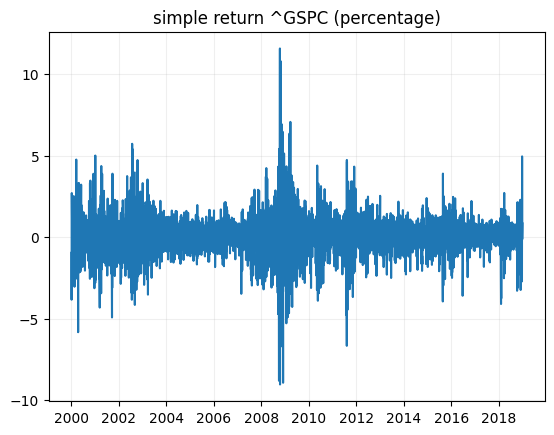

In [29]:
plt.figure()
plt.grid(alpha=0.2)
plt.plot(df_gspc["simple_return"])
plt.title('simple return ^GSPC (percentage)')

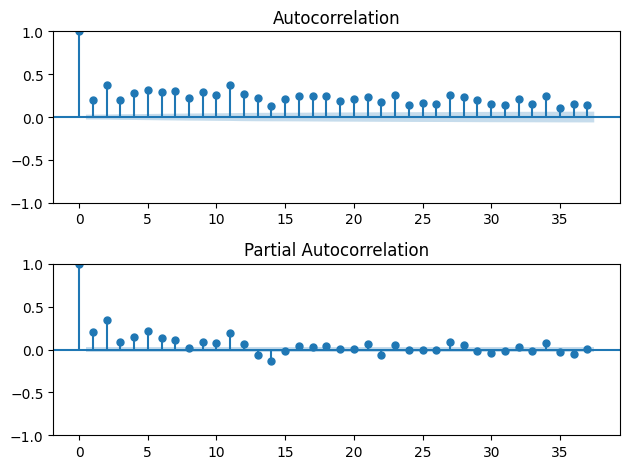

In [30]:
f, ax = plt.subplots(nrows=2, ncols=1)
plot_acf(df_gspc["simple_return"]**2, ax=ax[0])
plot_pacf(df_gspc["simple_return"]**2, ax=ax[1], method="ols")
plt.tight_layout()
plt.show()

In [31]:
adf_gspc = adf_test(df_gspc["simple_return"]**2)

Results of Dickey-Fuller Test:
Test Statistic                -6.016961e+00
p-value                        1.525568e-07
#Lags Used                     3.200000e+01
Number of Observations Used    4.746000e+03
Critical Value (1%)           -3.431729e+00
Critical Value (5%)           -2.862149e+00
Critical Value (10%)          -2.567094e+00
dtype: float64


In [32]:
from arch import arch_model
# START FROM 2,2, ONE OF THE COEFFICIENT IS DOGSHIT BUT WHATEVER, YOU WANT TO FIT YOU FALL INTO THE REALM OF SUSSY P HACKING
am = arch_model(df_gspc["simple_return"], p =2, q =2)
res = am.fit(update_freq=5)
print(res.summary())

Iteration:      5,   Func. Count:     49,   Neg. LLF: 9826.590017125145
Iteration:     10,   Func. Count:     90,   Neg. LLF: 6533.3934414265195
Iteration:     15,   Func. Count:    128,   Neg. LLF: 6530.450299905588
Optimization terminated successfully    (Exit mode 0)
            Current function value: 6530.450299905588
            Iterations: 15
            Function evaluations: 128
            Gradient evaluations: 15
                     Constant Mean - GARCH Model Results                      
Dep. Variable:          simple_return   R-squared:                       0.000
Mean Model:             Constant Mean   Adj. R-squared:                  0.000
Vol Model:                      GARCH   Log-Likelihood:               -6530.45
Distribution:                  Normal   AIC:                           13072.9
Method:            Maximum Likelihood   BIC:                           13111.7
                                        No. Observations:                 4779
Date:               

In [33]:
from plotly.subplots import make_subplots

fig = make_subplots(specs=[[{"secondary_y": True}]])
fig.add_trace(
    go.Scatter(x=df_gspc["simple_return"].index, y=df_gspc["simple_return"], mode="lines", name="simple return ^GSPC"),
    secondary_y=False,
)
fig.add_trace(
    go.Scatter(
        x=res.conditional_volatility.index,
        y=res.conditional_volatility * np.sqrt(252),
        mode="lines",
        name="IN SAMPLE GARCH VOL",
    ),
    secondary_y=True,
)
fig.update_layout(title="Simple Return (percentage) and GARCH(2,2) In Sample Vol")
fig.show()

In [34]:
fig = make_subplots(specs=[[{"secondary_y": True}]])
fig.add_trace(
    go.Scatter(x=df_vix.index, y=df_vix["close"], mode="lines", name="VIX CLOSE"),
    secondary_y=False,
)
fig.add_trace(
    go.Scatter(
        x=res.conditional_volatility.index,
        y=res.conditional_volatility * np.sqrt(252),
        mode="lines",
        name="IN SAMPLE GARCH VOL",
    ),
    secondary_y=False,
)
fig.update_layout(title="VIX and GARCH(2,2) In Sample Vol")
fig.show()
print(f"in sample mean GARCH(2,2) :{(res.conditional_volatility * np.sqrt(252)).mean()}")
print(f"in sample std GARCH(2,2) :{(res.conditional_volatility * np.sqrt(252)).std()}")

in sample mean GARCH(2,2) :16.688879203893453
in sample std GARCH(2,2) :9.179599080962397


In [35]:
# ROLLING FORECAST , THANK YOU YOUTUBE MAN
# https://www.youtube.com/watch?v=NKHQiN-08S8
rolling_pred =[]
test_size = len(df_vix_test)

for i in range(test_size):
    train = df_gspc_all[:-(test_size-i)]
    model = arch_model(train["simple_return"], p =2, q =2)
    res = model.fit(disp= 'off')
    pred = res.forecast(horizon=1)
    rolling_pred.append(np.sqrt(pred.variance.values[-1,:][0]))
rolling_pred = pd.Series(rolling_pred, index = df_vix_test.index)



In [36]:
fig = make_subplots(specs=[[{"secondary_y": True}]])
fig.add_trace(
    go.Scatter(x=df_vix_test.index, y=df_vix_test["close"], mode="lines", name="VIX CLOSE"),
    secondary_y=False,
)
fig.add_trace(
    go.Scatter(
        x=rolling_pred.index,
        y=rolling_pred * np.sqrt(252),
        mode="lines",
        name="OUT SAMPLE GARCH VOL",
    ),
    secondary_y=False,
)
fig.update_layout(title="VIX and GARCH(2,2) In Sample Vol")
fig.show()
print(f" Mean Abs Percentage Error(%) vs VIX:{mean_absolute_percentage_error(df_vix_test["close"], prediction)} %")


 Mean Abs Percentage Error(%) vs VIX:0.06615809828356785 %


# 2B. TRY LOG RETURN? ABANDON THIS

Text(0.5, 1.0, 'log return ^GSPC')

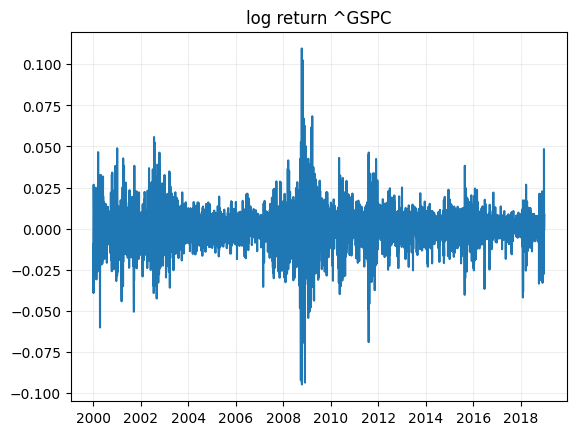

In [37]:
plt.figure()
plt.grid(alpha=0.2)
plt.plot(df_gspc["log_return"])
plt.title('log return ^GSPC')

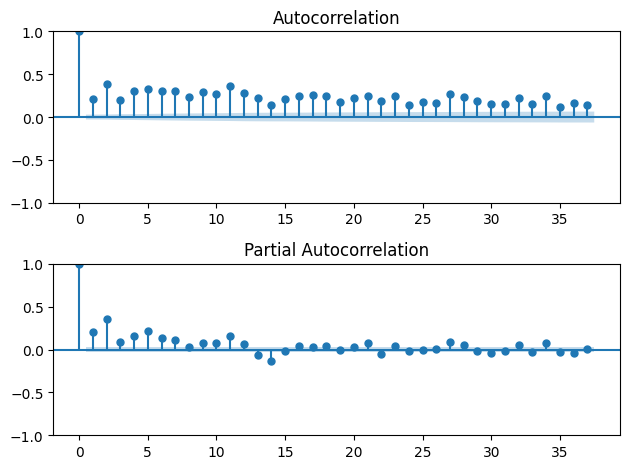

In [38]:
f, ax = plt.subplots(nrows=2, ncols=1)
plot_acf(df_gspc["log_return"]**2, ax=ax[0])
plot_pacf(df_gspc["log_return"]**2, ax=ax[1], method="ols")
plt.tight_layout()
plt.show()

In [39]:
adf_gspc = adf_test(df_gspc["log_return"]**2)

Results of Dickey-Fuller Test:
Test Statistic                -5.945449e+00
p-value                        2.209806e-07
#Lags Used                     3.200000e+01
Number of Observations Used    4.746000e+03
Critical Value (1%)           -3.431729e+00
Critical Value (5%)           -2.862149e+00
Critical Value (10%)          -2.567094e+00
dtype: float64


In [40]:
# START FROM 2,2, I HAVE TO HACK IT BECAUSE IF NOT THE P VALUES ARE TERRIBLE
am = arch_model(df_gspc["log_return"], p =1, q =2)
res = am.fit(update_freq=5)
print(res.summary())

Iteration:      5,   Func. Count:     62,   Neg. LLF: 1.4881054021638386e+19
Optimization terminated successfully    (Exit mode 0)
            Current function value: -15438.23680370332
            Iterations: 11
            Function evaluations: 91
            Gradient evaluations: 7
                     Constant Mean - GARCH Model Results                      
Dep. Variable:             log_return   R-squared:                       0.000
Mean Model:             Constant Mean   Adj. R-squared:                  0.000
Vol Model:                      GARCH   Log-Likelihood:                15438.2
Distribution:                  Normal   AIC:                          -30866.5
Method:            Maximum Likelihood   BIC:                          -30834.1
                                        No. Observations:                 4779
Date:                Sat, Nov 02 2024   Df Residuals:                     4778
Time:                        14:57:56   Df Model:                            1
   

In [41]:
fig = make_subplots(specs=[[{"secondary_y": True}]])
fig.add_trace(
    go.Scatter(x=df_gspc["log_return"].index, y=df_gspc["log_return"], mode="lines", name="log return ^GSPC"),
    secondary_y=False,
)
fig.add_trace(
    go.Scatter(
        x=res.conditional_volatility.index,
        y=res.conditional_volatility * np.sqrt(252) * 100,
        mode="lines",
        name="IN SAMPLE GARCH VOL",
    ),
    secondary_y=True,
)
fig.update_layout(title="Log Return and GARCH(1,2) In Sample Vol")
fig.show()

In [42]:
fig = make_subplots(specs=[[{"secondary_y": True}]])
fig.add_trace(
    go.Scatter(x=df_vix.index, y=df_vix["close"], mode="lines", name="VIX CLOSE"),
    secondary_y=False,
)
fig.add_trace(
    go.Scatter(
        x=res.conditional_volatility.index,
        y=res.conditional_volatility * np.sqrt(252)*100,
        mode="lines",
        name="IN SAMPLE GARCH VOL",
    ),
    secondary_y=False,
)
fig.update_layout(title="VIX and GARCH(1,2) In Sample Vol")
fig.show()

In [43]:
df_gspc_all['log_return']

Date
2000-01-03   -0.009595
2000-01-04   -0.039099
2000-01-05    0.001920
2000-01-06    0.000955
2000-01-07    0.026730
                ...   
2024-04-15   -0.012094
2024-04-16   -0.002059
2024-04-17   -0.005797
2024-04-18   -0.002211
2024-04-19   -0.008797
Name: log_return, Length: 6113, dtype: float64

In [44]:
# ROLLING FORECAST , THANK YOU YOUTUBE MAN
# https://www.youtube.com/watch?v=NKHQiN-08S8
rolling_pred =[]
test_size = len(df_vix_test)

for i in range(test_size):
    train = df_gspc_all[:-(test_size-i)]
    model = arch_model(train["log_return"], p =1, q =2)
    res = model.fit(disp= 'off')
    pred = res.forecast(horizon=1)
    rolling_pred.append(np.sqrt(pred.variance.values[-1,:][0]))
rolling_pred = pd.Series(rolling_pred, index = df_vix_test.index)

/home/kilo/.local/lib/python3.12/site-packages/arch/univariate/base.py:766: ConvergenceWarning:

The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.


/home/kilo/.local/lib/python3.12/site-packages/arch/univariate/base.py:766: ConvergenceWarning:

The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.


/home/kilo/.local/lib/python3.12/site-packages/arch/univariate/base.py:766: ConvergenceWarning:

The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.


/home/kilo/.local/lib/python3.12/site-packages/arch/univariate/base.py:766: ConvergenceWarning:

The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.


/home/kilo/.local/lib/python3.12/site-packages/arch/univariate/base.py:766: Conv

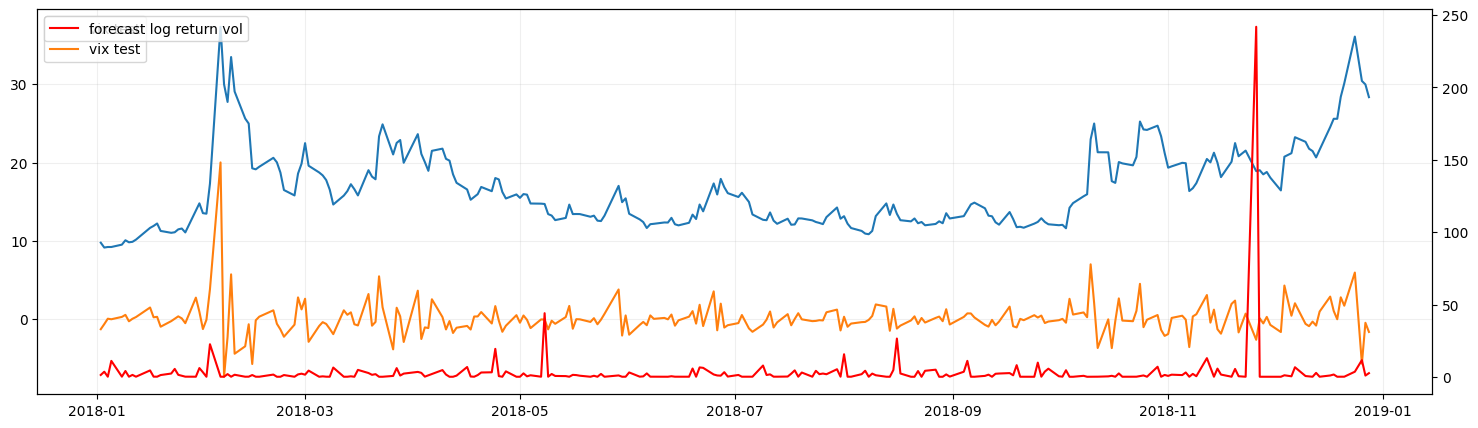

In [45]:
plt.figure(figsize=(18, 5))
plt.grid(alpha =0.2)
plt.plot(df_vix_test, label = 'vix test')
plt.legend(loc=0)

plt.gca().twinx().plot(rolling_pred * np.sqrt(252), label='forecast log return vol', color ='red')
plt.legend(loc=2)